In [55]:
# Example source:
# https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/
# https://github.com/tanishqgautam/Image-Captioning/blob/main/Attention/Image_caption_using_attention.ipynb

## Step 1:- Import the required libraries

### Here we will be making use of Tensorflow for creating our model and training it. The majority of the code credit goes to TensorFlow tutorials. You can make use of Google Colab or Kaggle notebooks if you want a GPU to train it.

In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [6]:
# https://www.kaggle.com/shadabhussain/flickr8k?select=Flickr_Data

## Step 2:- Data loading and Preprocessing

### Define our image and caption path and check how many total images are present in the dataset.

In [7]:
image_path = "./Flickr8k/Flickr8k_Dataset"
dir_Flickr_text = "./Flickr8k/Flick8k_Text/Flickr8k.token.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


### We create a dataframe to store the image id and captions for ease of use.

In [8]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


### Next, let’s visualize a few images and their 5 captions:

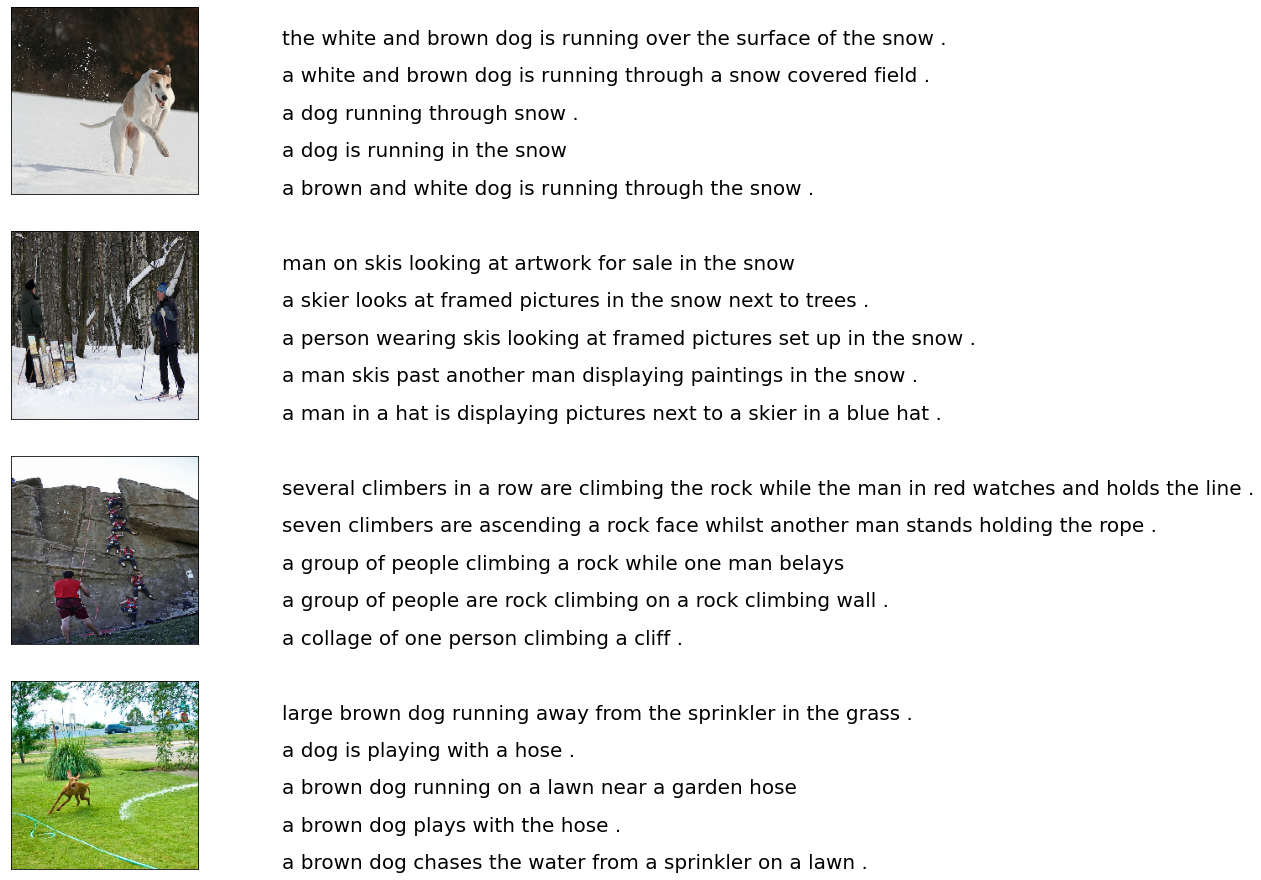

In [9]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

### Next let’s see what our current vocabulary size is:-



In [10]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


### Next perform some text cleaning such as removing punctuation, single characters, and numeric values:

In [11]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

### Now let’s see the size of our vocabulary after cleaning-

In [12]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


### Next, we save all the captions and image paths in two lists so that we can load the images at once using the path set. We also add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption.

In [13]:
PATH = "./Flickr8k/Flickr8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption + ' <end>'
    all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [14]:
all_img_name_vector = []
for annot in data["filename"]:
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['./Flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flickr8k/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flickr8k/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flickr8k/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flickr8k/Flickr8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flickr8k/Flickr8k_Dataset/1001773457_577c3a7d70.jpg']

### Now you can see we have 40455 image paths and captions.

In [15]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


### We will take only 40000 of each so that we can select batch size properly i.e. 625 batches if batch size= 64. To do this we define a function to limit the dataset to 40000 images and captions.

In [16]:
def data_limiter(num,all_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

## Step 3:- Model Definition


### Let’s define the image feature extraction model using VGG16. We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the model. We must all preprocess all the images to the same size, i.e, 224×224 before feeding them into the model.

In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

### Next, let’s Map each image name to the function to load the image:-

In [18]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

### We extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [19]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [37:09<00:00, 17.55s/it]

Wall time: 37min 9s


### Next, we tokenize the captions and build a vocabulary of all the unique words in the data. We will also limit the vocabulary size to the top 5000 words to save memory. We will replace words not in vocabulary with the token < unk >

In [20]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

### Let’s visualize the padded training and captions and the tokenized vectors:

In [21]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [22]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

### Next, we can calculate the max and min length of all captions:

In [23]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
    return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


### Next, Create training and validation sets using an 80-20 split:

In [24]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)


### Define the parameters for training:

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

### Next, let’s create a tf.data dataset to use for training our model.

In [26]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                      map_func, [item1, item2], [tf.float32, tf.int32]),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Next, let’s define the encoder-decoder architecture with attention. The architecture defined in this article is similar to the one described in the paper “Show and Tell: A Neural Image Caption Generator”:-

### The VGG-16 Encoder is defined below:-

In [27]:
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x 

### We define our RNN based on GPU/CPU capabilities-

In [28]:
def rnn_type(units):
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                                   return_sequences=True,
                                                   return_state=True,
                                                   recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_activation='sigmoid',
                                   recurrent_initializer='glorot_uniform')

### Next, define the RNN Decoder with Bahdanau Attention:

In [29]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        # features shape ==> (64,49,256) ==> Output from ENCODER
        # hidden shape == (batch_size, hidden_size) ==>(64,512)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (64, 49, 1)
        # Attention Function
        '''e(ij) = f(s(t-1),h(j))'''
        ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

        # self.Uattn(features) : (64,49,512)
        # self.Wattn(hidden_with_time_axis) : (64,1,512)
        # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
        # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

        # you get 1 at the last axis because you are applying score to self.Vattn
        # Then find Probability using Softmax
        '''attention_weights(alpha(ij)) = softmax(e(ij))'''

        attention_weights = tf.nn.softmax(score, axis=1)

        # attention_weights shape == (64, 49, 1)
        # Give weights to the different pixels in the image
        ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
        # context_vector shape after sum == (64, 256)
        # x shape after passing through embedding == (64, 1, 256)

        x = self.embedding(x)
        # x shape after concatenation == (64, 1,  512)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU

        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)

        x = self.fc1(output)
        # x shape == (batch_size * max_length, hidden_size)

        x = tf.reshape(x, (-1, x.shape[2]))

        # Adding Dropout and BatchNorm Layers
        x= self.dropout(x)
        x= self.batchnormalization(x)

        # output shape == (64 * 512)
        x = self.fc2(x)

        # shape : (64 * 8329(vocab))
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

### Next, we define the loss function and optimizers:-

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Step 4:- Model Training

### Next, let’s define the training step. We make use of a technique called Teacher Forcing, which is the technique where the target word is passed as the next input to the decoder. This technique helps to learn the correct sequence or correct statistical properties for the sequence, quickly.

In [31]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
             # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### Next, we train the model:-

In [32]:
# https://github.com/tensorflow/models/issues/9706#issuecomment-877788105

In [33]:
EPOCHS = 20
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                   epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))

    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6984
Epoch 1 Batch 100 Loss 1.6986
Epoch 1 Batch 200 Loss 1.4032
Epoch 1 Batch 300 Loss 1.3230
Epoch 1 Batch 400 Loss 1.3012
Epoch 1 Loss 1.477307
Time taken for 1 epoch 1191.2024669647217 sec

Epoch 2 Batch 0 Loss 1.1191
Epoch 2 Batch 100 Loss 1.2287
Epoch 2 Batch 200 Loss 1.0625
Epoch 2 Batch 300 Loss 1.0590
Epoch 2 Batch 400 Loss 1.0403
Epoch 2 Loss 1.126379
Time taken for 1 epoch 1149.0311760902405 sec

Epoch 3 Batch 0 Loss 1.0324
Epoch 3 Batch 100 Loss 1.0060
Epoch 3 Batch 200 Loss 0.9995
Epoch 3 Batch 300 Loss 0.9764
Epoch 3 Batch 400 Loss 0.9352
Epoch 3 Loss 1.007702
Time taken for 1 epoch 1155.8470821380615 sec

Epoch 4 Batch 0 Loss 0.7868
Epoch 4 Batch 100 Loss 0.9459
Epoch 4 Batch 200 Loss 0.9277
Epoch 4 Batch 300 Loss 0.8742
Epoch 4 Batch 400 Loss 0.9386
Epoch 4 Loss 0.924312
Time taken for 1 epoch 1154.3672277927399 sec

Epoch 5 Batch 0 Loss 0.8880
Epoch 5 Batch 100 Loss 0.8411
Epoch 5 Batch 200 Loss 0.8574
Epoch 5 Batch 300 Loss 0.8331
Epoch 5 Batch 

### Let’s plot the error graph:

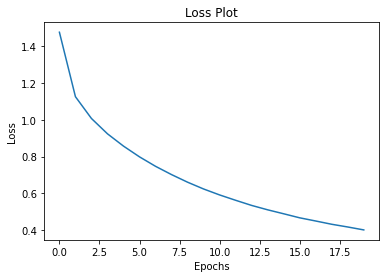

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Step 5:- Greedy Search and BLEU Evaluation

### Let’s define our greedy method of defining captions:

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

### Also, we define a function to plot the attention maps for each word generated as we saw in the introduction-

In [37]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Finally, let’s generate a caption for the image at the start of the article and see what the attention mechanism focuses on and generates-

BELU score: 5.969061643530969e-153
Real Caption: the man takes leap into the water with his shoes on
Prediction Caption: the man in blue begins to catch his sneakers on his head


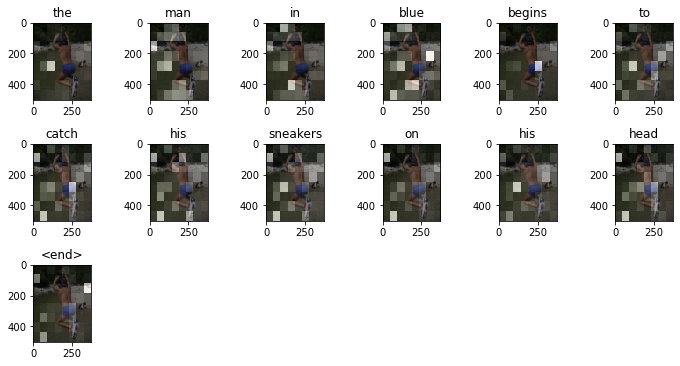

In [54]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

### You can see we were able to generate the same caption as the real caption. Let’s try it out for some other images from the test set.

Real Caption: black and tan dog in the snow
Prediction Caption: husky dog is turning its head


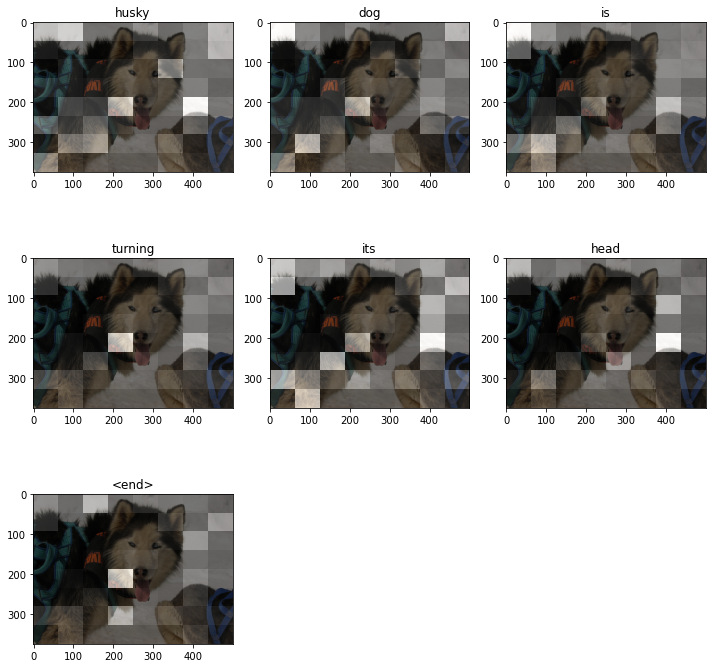

time took to Predict: 1 sec


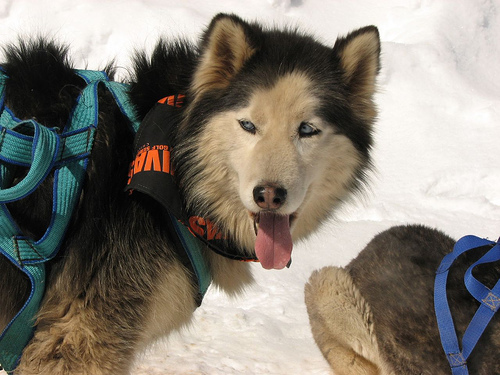

In [52]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

### You can see even though our caption is quite different from the real caption, it is still very accurate. It was able to identify the yellow shirt of the woman and her hands in the pocket.

### Let’s see another one:

BELU score: 4.7975972319129444e-76
Real Caption: black dog is digging in the snow
Prediction Caption: dog in its mouth in the snow


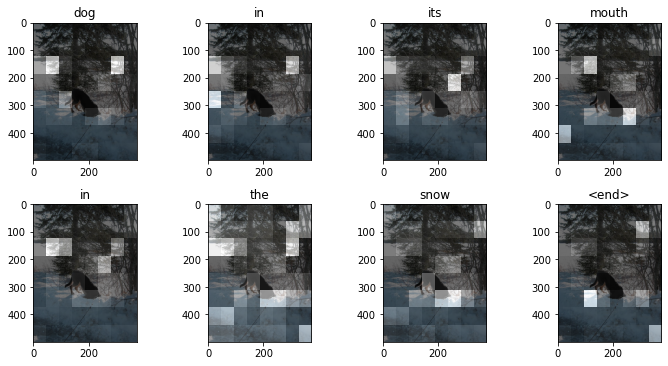

In [53]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

### Here we can see our caption defines the image better than one of the real captions.

### And there it is!  We have successfully implemented the Attention Mechanism for generating Image Captions

## What’s Next?

### The attention mechanism is highly utilized in recent years and is just the start to much more state of the art systems. Things you can implement to improve your model:-

- Make use of the larger datasets, especially the MS COCO dataset or the Stock3M dataset which is 26 times larger than MS COCO.
- Implement different attention mechanisms like Adaptive Attention with Visual Sentinel and. Semantic Attention
- Implementing a Transformer based model which should perform much better than an LSTM.
- Implementing better architecture for image feature extraction like Inception, Xception, and Efficient networks.

## End Notes

### This was quite an interesting look at the Attention mechanism and how it applies to deep learning applications. There has been immense research in the attention mechanism and achieving a state of the art results.

### Make sure to try some of my suggestions to improve the performance of our generator and share your results with me!

### Did you find this article helpful? Do share your valuable feedback in the comments section below. Feel free to share your complete code notebooks as well which will be helpful to our community members.